In [1]:
from common import *
from pandas.api.types import CategoricalDtype
from numba import njit

from sklearn.preprocessing import QuantileTransformer as QT
from scipy.stats import norm
ppf = norm.ppf

In [2]:
from given import *


# ------------------------------> looking at `W`

In [19]:
#pd.to_pickle((F,P), '/big/data/saves/train_5searchbase.32.pkl')
F,P = pd.read_pickle('/big/data/saves/train_5fixedsince+1.32.pkl')

### stock subsets

In [20]:
Mt = M[M.time>=train_start_time]

In [5]:
# # already in given.ipynb
# inUniCount = Mt.groupby('assetCodeId').universe.sum()
# stocksInUni = (inUniCount != 0).pipe(lambda x: x.index[x])
# assert stocksInUni.is_monotonic
# xStocksInUni = set(stocksInUni) #EDITCELL

In [25]:
W = O()
W.y1 = Mt[['time','assetCodeId','oo']].pivot('time','assetCodeId').oo
W.ay1 = Mt[['time','assetCodeId','aoo']].pivot('time','assetCodeId').aoo
W.y10 = Mt[['time','assetCodeId','ooTEN']].pivot('time','assetCodeId').ooTEN
W.ay10 = Mt[['time','assetCodeId','aooTEN']].pivot('time','assetCodeId').aooTEN
W.u = Mt[['time','assetCodeId','universe']].pivot('time','assetCodeId').universe.fillna(0).astype(int)

In [27]:
C = O()
C.y1 = W.y1.corr()
C.ay1 = W.ay1.corr()
C.y10 = W.y10.corr()
C.ay10 = W.ay10.corr()
C.u = W.u.T @ W.u

In [24]:
@njit
def offdiag_items(ix, x, y):
    m, n = x.shape
    assert (m, n) == y.shape
    assert m == n
    assert (m,) == ix.shape
    t = (n**2-n) // 2
    I = np.full(t, -1, dtype=np.int64)
    J = np.full(t, -1, dtype=np.int64)
    X = np.full(t, 0, dtype=x.dtype)
    Y = np.full(t, 0, dtype=y.dtype)
    k = -1
    for i in range(m):
        for j in range(i+1, n):
            k += 1
            I[k] = ix[i]
            J[k] = ix[j]
            X[k] = x[i,j]
            Y[k] = y[i,j]
    return I, J, X, Y

In [5]:
#pd.to_pickle((O.py(W),O.py(C)), big_data/'pair/working_2ONEorTEN.pkl')
(W, C) = pd.read_pickle(big_data/'pair/working_2ONEorTEN.pkl'); W, C = O(**W), O(**C)

In [25]:
D = O()
D.v1 = pd.DataFrame(dict(zip([0, 1, 'Corr', 'Unic'], offdiag_items(C.y1.index.values, C.y1.values, C.u.values))))
D.av1 = pd.DataFrame(dict(zip([0, 1, 'Corr', 'Unic'], offdiag_items(C.ay1.index.values, C.ay1.values, C.u.values))))
D.v10 = pd.DataFrame(dict(zip([0, 1, 'Corr', 'Unic'], offdiag_items(C.y10.index.values, C.y10.values, C.u.values))))
D.av10 = pd.DataFrame(dict(zip([0, 1, 'Corr', 'Unic'], offdiag_items(C.ay10.index.values, C.ay10.values, C.u.values))))

In [79]:
for c in ['v1','av1','v10','av10']:
    D[c] = D[c][D[c].Unic!=0]
    D[c].sort_values('Corr', ascending=False, inplace=True)

In [109]:
'GOOG.O' in set(assetCodeIdAssign.series)
'MSFT.O' in set(assetCodeIdAssign.series)
'FB.O' in set(assetCodeIdAssign.series)
'AAPL.O' in set(assetCodeIdAssign.series)

True

In [114]:
guy[(guy[0]=='AAPL.O')&(guy[1]=='MSFT.O')]

,0,1,10,11,Corr,Unic
11111,AAPL.O,MSFT.O,Apple Inc,Microsoft Corp,0.099926,2014


In [149]:
guy = D.av10.copy()
guy[10] = guy[0].map(assetCodeMapName).map(assetNameIdAssign.series)
guy[11] = guy[1].map(assetCodeMapName).map(assetNameIdAssign.series)
guy[0] = guy[0].map(assetCodeIdAssign.series)
guy[1] = guy[1].map(assetCodeIdAssign.series)
guy = guy.reindex([0,1,10,11,'Corr','Unic'], axis=1)
guy[guy.Unic>=500].pipe(lambda x: x[(-1<=x.Corr)&(x.Corr<=1)]).reset_index(drop=True).tail(200)

,0,1,10,11,Corr,Unic
665913,XEL.N,SC.N,Xcel Energy Inc,Santander Consumer USA Holdings Inc,-0.399033,682
665914,AEE.N,CFG.N,Ameren Corp,Citizens Financial Group Inc,-0.399043,517
665915,SNH.N,AMTD.N,Senior Housing Properties Trust,TD Ameritrade Holding Corp,-0.399279,915
665916,ETFC.O,DUK.N,E*TRADE Financial Corp,Duke Energy Corp,-0.399332,1113
665917,NEM.N,SNV.N,Newmont Mining Corp,Synovus Financial Corp,-0.399682,642
665918,DD.N,BRX.N,E I du Pont de Nemours and Co,Brixmor Property Group Inc,-0.400230,616
665919,T.N,ISBC.O,AT&T Inc,Investors Bancorp Inc,-0.400316,649
665920,WDAY.N,EVHC.N,Workday Inc,Envision Healthcare Corp,-0.400572,567
665921,CAG.N,SHPG.O,Conagra Brands Inc,Shire PLC,-0.401842,551
665922,VZ.N,SC.N,Verizon Communications Inc,Santander Consumer USA Holdings Inc,-0.402578,682


In [135]:
Mt[Mt.assetCode=='LPLA.O'].head()

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe,assetCodeId,assetNameId,cc,oo,acc,aoo,ccTEN,ooTEN,accTEN,aooTEN,dayOfYear,dayOfWeek
2162277,2012-07-19 22:00:00+00:00,LPLA.O,LPL Financial Holdings Inc,147147.0,33.18,33.88,-0.018053,-0.005577,NaN,NaN,-0.018924,-0.006452,NaN,NaN,-0.173549,0.0,2864,2710,-0.018218,-0.005592,NaN,NaN,-0.019105,-0.006473,NaN,NaN,201.0,3.0
2163978,2012-07-20 22:00:00+00:00,LPLA.O,LPL Financial Holdings Inc,135500.0,32.42,32.88,-0.022905,-0.029516,-0.018451,-0.029748,-0.041112,-0.020554,NaN,NaN,-0.150137,0.0,2864,2710,-0.023172,-0.029960,-0.018623,-0.030199,-0.041981,-0.020768,NaN,NaN,202.0,4.0
2165679,2012-07-23 22:00:00+00:00,LPLA.O,LPL Financial Holdings Inc,132160.0,32.33,32.00,-0.002776,-0.026764,0.001802,-0.024652,-0.034925,-0.050445,NaN,NaN,-0.126479,0.0,2864,2710,-0.002780,-0.027129,0.001801,-0.024961,-0.035550,-0.051762,NaN,NaN,205.0,0.0
2167380,2012-07-24 22:00:00+00:00,LPLA.O,LPL Financial Holdings Inc,362194.0,31.79,32.41,-0.016703,0.012812,-0.011385,0.013671,-0.063899,-0.040557,NaN,NaN,-0.072400,0.0,2864,2710,-0.016844,0.012731,-0.011450,0.013579,-0.066032,-0.041402,NaN,NaN,206.0,1.0
2169080,2012-07-25 22:00:00+00:00,LPLA.O,LPL Financial Holdings Inc,115180.0,31.96,31.76,0.005348,-0.020056,0.005490,-0.018047,-0.065224,-0.063679,NaN,NaN,-0.065718,0.0,2864,2710,0.005333,-0.020259,0.005475,-0.018212,-0.067448,-0.065797,NaN,NaN,207.0,2.0


<IPython.core.display.Javascript object>


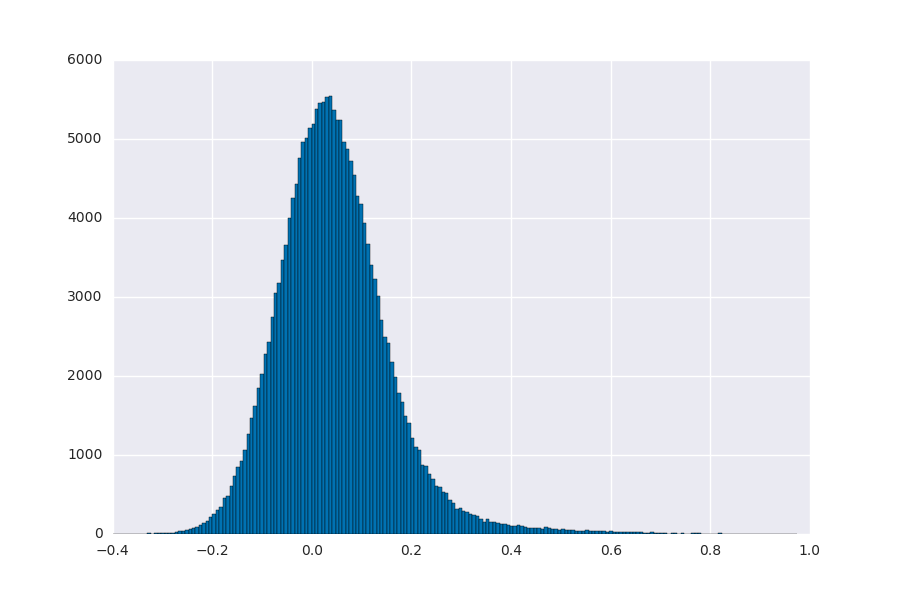

In [175]:
guy[guy.Unic>=1500].Corr.hist(bins=200);

#### making pair feature table

In [62]:
def make_CC_G_Q_from_Dl_F_P_W(*, Dl, F, P, W, hi=None, lo, roll_corr=list(product(['ay1','ay10'],[10,21,62,250]))):
    D = Dl
    allTime = pd.Series(P.time.unique())
    allTime.index = allTime
    
    if hi is None:
        hi = (1., 9999)
    D = D[(lo[0]<=D.Corr)&(D.Corr<=hi[0])&(lo[1]<=D.Unic)&(D.Unic<=hi[1])]
    hgt = sum(p[-1] for p in D.itertuples())
    CC = np.zeros((hgt,1+len(roll_corr)))
    G0, G1 = np.zeros((hgt,len(F.columns))), np.zeros((hgt,len(F.columns)))
    Q0, Q1 = [], []
    
    i = 0
    print(f'[{len(D)}]', end='')
    for ii, (_,a0,a1,corr,unic) in enumerate(D.itertuples()):
        print_progress(ii)
        
        in0, in1 = (F.assetCodeId==a0)&(P.universe!=0), (F.assetCodeId==a1)&(P.universe!=0)
        A0, A1 = F[in0], F[in1]
        B0, B1 = P[in0], P[in1]
        inTime = set(B0.time)&set(B1.time)
        tm0, tm1 = B0.time.isin(inTime), B1.time.isin(inTime)
        A0, A1 = A0[tm0], A1[tm1]
        B0, B1 = B0[tm0], B1[tm1]
        
        tm = allTime.isin(inTime).values
        def iter_roll_corr():
            for y, r in roll_corr:
                yield W[y][a0].rolling(window=r, min_periods=5).corr(W[y][a1])[tm] #TODO hard coded min_periods
        C = np.stack(chain(iter_roll_corr(),[np.ones_like(W[next(iter(W))].iloc[:,0][tm])*unic]), axis=1)
        
        G0[i:i+unic], G1[i:i+unic] = A0.values, A1.values
        Q0.append(B0); Q1.append(B1);
        CC[i:i+unic] = C
        
        i += unic
        
    Q0, Q1 = pd.concat(Q0, axis=0), pd.concat(Q1, axis=0)
    G0, G1 = pd.DataFrame(G0, index=Q0.index, columns=F.columns), pd.DataFrame(G1, index=Q1.index, columns=F.columns)
    C = pd.DataFrame(CC, columns=[f'_corr_{y}_{r}' for y,r in roll_corr]+['bothInUniCount'])
    return C, (G0,G1), (Q0,Q1)

In [169]:
%%time
CC, G, Q = make_CC_G_Q_from_Dl_F_P_W(Dl=D.av10,F=F,P=P,W=W,lo=(-.6,500),hi=(-.5,9999))

[37]0.........10.........20.........30......CPU times: user 6 s, sys: 225 ms, total: 6.23 s
Wall time: 6.21 s


<IPython.core.display.Javascript object>


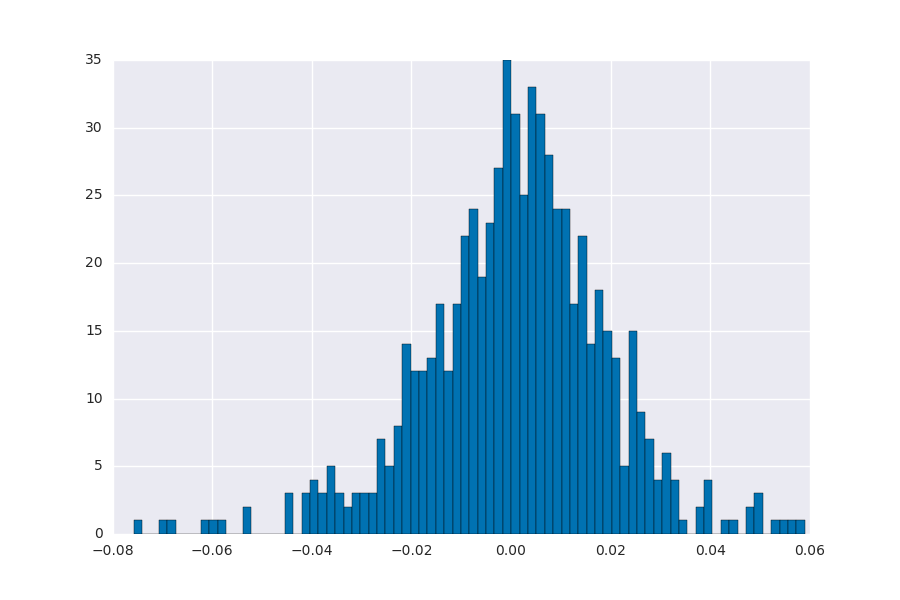

In [180]:
# see scatter of pairs with corr whatever
[[a0, a1]] = pd.DataFrame(np.stack([G[0].assetCodeId,G[1].assetCodeId],axis=1)).drop_duplicates().pipe(sample(1)).values
(W.ay1[a0]-W.ay1[a1]).hist(bins=80);
#plt.axes().set_aspect('equal')

#### old way of doing it

In [7]:
C.av1.head()

,0,1,Corr,Unic
0,0,1,0.145701,0
1,0,2,0.173884,1703
2,0,3,0.245055,2014
3,0,4,0.357883,2014
4,0,5,0.282466,2014


In [8]:
F['time'] = P.time
#F[['oo','time','assetCodeId']].head()#.pivot('time','assetCodeId')

In [7]:
def make_E_from_F_P(*, F, P):
    # add stuff to F I need
    F['time'] = P.time
    F['universe'] = P.universe.fillna(0) # not removed because need it for generating pair features
    F['assetCodeIdPivot'] = F.assetCodeId.astype(int)
    # the pivot ===============\___
    E = F.pivot('time','assetCodeIdPivot')
    # remove stuff I added to F
    del F['time'], F['universe'], F['assetCodeIdPivot']
    # end block
    
    E.columns = E.columns.swaplevel()
    E = E.sort_index(axis=1)
    E.columns.rename('assetCodeId', level=0, inplace=True)
    return E

In [28]:
E = make_E_from_F_P(F=F[['assetCodeId','oo','oo1','oo10','oo(15-5)','aoo1','aoo10','aoo(15-5)']], P=P)

In [8]:
#pd.to_pickle(E, big_data/'pair/E_2ONEorTEN.pkl')
E = pd.read_pickle(big_data/'pair/E_2ONEorTEN.pkl')

In [221]:
def make_C_D_L_from_E_Cv(*, E, Cv, cutoff, roll_corr=list(product(['oo','ooTEN'],[10,21,62,250]))):
    Cv = Cv[(Cv.Corr>=cutoff[0])&(Cv.Unic>=cutoff[1])]
    hgt = sum(p[-1] for p in Cv.itertuples())
    Fcolumns = [c for c in E.columns.levels[1] if c!='universe']
    D0, D1, L = np.zeros((hgt,len(Fcolumns))), np.zeros((hgt,len(Fcolumns))), np.zeros((hgt,1+len(roll_corr)))
    #^ -1 on len(Fcolumns) because I take away the 'universe' column
    
    i = 0
    for ii, (_,a0,a1,corr,unic) in enumerate(Cv.itertuples()):
        print_progress(ii)
        A0, A1 = E[a0], E[a1]
        inUniD = (A0.universe.fillna(0)!=0) & (A1.universe.fillna(0)!=0)
        assert inUniD.sum()==unic
        del A0['universe'], A1['universe']
        
        def iter_roll_corr():
            for y, r in roll_corr:
                if a0==1782 and a1==2523 and r==10:
                    BUG.x0 = A0[y]#[inUniD]
                    BUG.x1 = A1[y]#[inUniD]
                yield A0[y].rolling(window=r, min_periods=5).corr(A1[y]) #TODO hard coded min_periods
        B = np.stack(chain(iter_roll_corr(),[np.ones_like(A0.iloc[:,0])*unic]), axis=1)
        
        D0[i:i+unic], D1[i:i+unic] = A0[inUniD].values, A1[inUniD].values
        L[i:i+unic] = B[inUniD]
        
        i += unic
        
    D0 = pd.DataFrame(D0, columns=Fcolumns)
    D1 = pd.DataFrame(D1, columns=Fcolumns)
    L = pd.DataFrame(L, columns=[f'_corr_{y}_{r}' for y,r in roll_corr]+['bothInUniCount'])
    return (D0,D1), L

In [222]:
%%time
D, L = make_C_D_L_from_E_Cv(E=E,Cv=C.av1,cutoff=(.8,500))

0.........10.........20....CPU times: user 1.95 s, sys: 298 ms, total: 2.25 s
Wall time: 2.23 s


# ------------------------------> looking at `N`